In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

from datetime import datetime
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader

In [ ]:
class AiWritingDataset(Dataset):
    def __init__(self, csv_file):
        self.data = pd.read_csv(csv_file)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        if isinstance(idx, int):
          sub = self.data.iloc[[idx]]
        else:
          sub = self.data.iloc[idx]
        y = sub["y"].to_numpy()
        X = sub.drop(columns=["y"])
        #X = X.drop(X.columns[0], axis=1)
        X = X.values

        return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32).reshape(-1, 1)

In [ ]:
train_data = AiWritingDataset("interp_train_nn2.csv")
test_data = AiWritingDataset("interp_test_nn2.csv")
train_dataloader = DataLoader(train_data, batch_size=512, shuffle=True, num_workers=0)
test_dataloader = DataLoader(test_data, batch_size=256, shuffle=False, num_workers=0)

In [ ]:
from collections import OrderedDict

class DenseNetwork(torch.nn.Module):
    def __init__(self, in_features, hidden_size, n_classes, n_layers, dropout, activation=nn.ReLU):
        super().__init__()

        self.layers = n_layers
        self.layer_size = hidden_size
        self.in_features = in_features
        self.activation = activation
        l = []
        if n_layers == 1:
          l.append(('linear0', nn.Linear(self.in_features, n_classes)))
        else:
          l.append(('linear0', nn.Linear(self.in_features, self.layer_size)))
          l.append(('relu0', self.activation()))
          for i in range(1, self.layers - 1):
            l.append((f'linear{i}', nn.Linear(self.layer_size, self.layer_size)))
            l.append((f'relu{i}', self.activation()))
            l.append((f'dropout{i}', nn.Dropout(p=dropout)))
          l.append(('linear_final', nn.Linear(self.layer_size, n_classes)))
          l.append(('sigmoid', nn.Sigmoid()))
        self.layers = nn.Sequential(OrderedDict(l))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.layers(x)

In [ ]:
import tqdm.notebook as tqdm
from functools import partial

def training_loop(n_epochs, test_every_it, network, loss_fn, optimizer, dl_train, dl_test, device):
    train_losses, test_losses, train_accuracies, test_accuracies = [], [], [], []
    for epoch in (pbar := tqdm.tqdm(range(n_epochs), total=n_epochs, leave=False)):

        network.train()

        for data, labels in tqdm.tqdm(dl_train, total=len(dl_train), leave=False):
            optimizer.zero_grad()
            loss = loss_fn(network(data.to(device)), labels.to(device))
            loss.backward()
            optimizer.step()

        if epoch % test_every_it == 0 or epoch == n_epochs - 1:
            network.eval()

            with torch.no_grad():
                losses_train = 0
                accuracies_train = 0

                for data, labels in dl_train:
                    train_out = network(data.to(device))
                    pred = train_out > 0.5
                    losses_train += loss_fn(train_out, labels.to(device)).item()
                    accuracies_train += torch.sum(pred == labels.to(device)).item() / labels.shape[0]

                losses_train /= len(dl_train)
                accuracies_train /= len(dl_train)
                accuracies_train *= 100

                losses_test = 0
                accuracies_test = 0

                for data, labels in dl_test:
                    test_out = network(data.to(device))
                    pred = test_out > 0.5
                    losses_test += loss_fn(test_out, labels.to(device)).item()
                    accuracies_test += torch.sum(pred == labels.to(device)).item() / labels.shape[0]
                losses_test /= len(dl_test)
                accuracies_test /= len(dl_test)
                accuracies_test *= 100

                test_losses.append(losses_test)
                test_accuracies.append(accuracies_test)
                train_losses.append(losses_train)
                train_accuracies.append(accuracies_train)

            pbar.set_description(
                'Loss (Train/Test): {0:.3f}/{1:.3f}. Accuracy, % (Train/Test): {2:.2f}/{3:.2f}\n'.format(
                    train_losses[-1], test_losses[-1], train_accuracies[-1], test_accuracies[-1]
                )
            )

    return train_losses, test_losses, train_accuracies, test_accuracies

In [ ]:
net = DenseNetwork(10, 32, 1, 5, 0.1)
print(net)
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda', 0)

net = net.to(device)

loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=2e-2)

DenseNetwork(
  (layers): Sequential(
    (linear0): Linear(in_features=10, out_features=32, bias=True)
    (relu0): ReLU()
    (linear1): Linear(in_features=32, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=32, out_features=32, bias=True)
    (relu2): ReLU()
    (dropout2): Dropout(p=0.1, inplace=False)
    (linear3): Linear(in_features=32, out_features=32, bias=True)
    (relu3): ReLU()
    (dropout3): Dropout(p=0.1, inplace=False)
    (linear_final): Linear(in_features=32, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)


In [ ]:
train_losses, test_losses, train_accs, test_accs = training_loop(
    n_epochs=20, test_every_it=5, network=net, loss_fn=loss_fn,
    optimizer=optimizer, dl_train=train_dataloader, dl_test=test_dataloader, device=device
)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

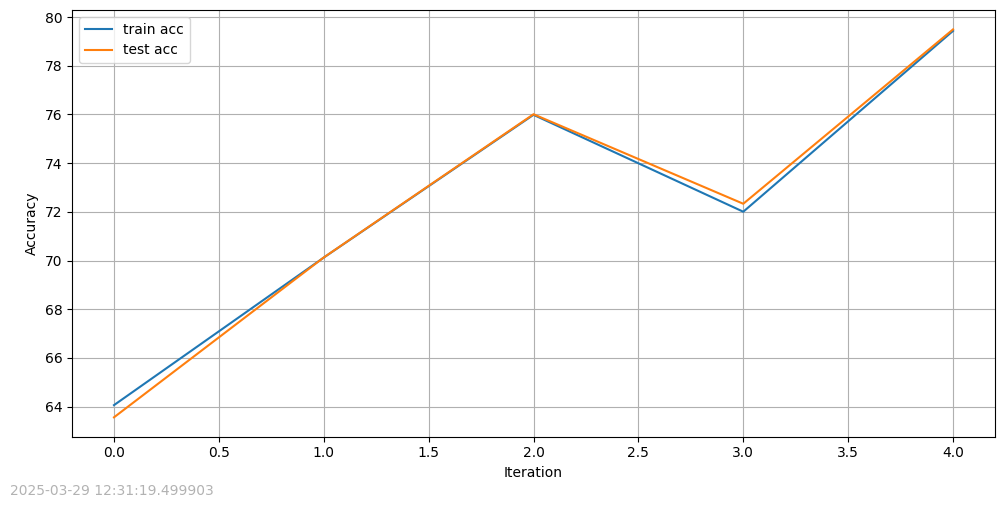

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(train_accs, label="train acc")
ax.plot(test_accs, label="test acc")
ax.set_xlabel("Iteration")
ax.set_ylabel("Accuracy")
ax.grid(True)
ax.legend()

fig.text(
    0.0, 0.0, str(datetime.now()),
    fontsize=10, color='gray', alpha=0.6,
)

fig.tight_layout()
plt.show()

In [ ]:
torch.save(net.state_dict(), "interp_sigmoid_do2.pth")

DenseNetwork(
  (layers): Sequential(
    (linear0): Linear(in_features=19, out_features=32, bias=True)
    (relu0): ReLU()
    (linear1): Linear(in_features=32, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=32, out_features=32, bias=True)
    (relu2): ReLU()
    (dropout2): Dropout(p=0.1, inplace=False)
    (linear3): Linear(in_features=32, out_features=32, bias=True)
    (relu3): ReLU()
    (dropout3): Dropout(p=0.1, inplace=False)
    (linear_final): Linear(in_features=32, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

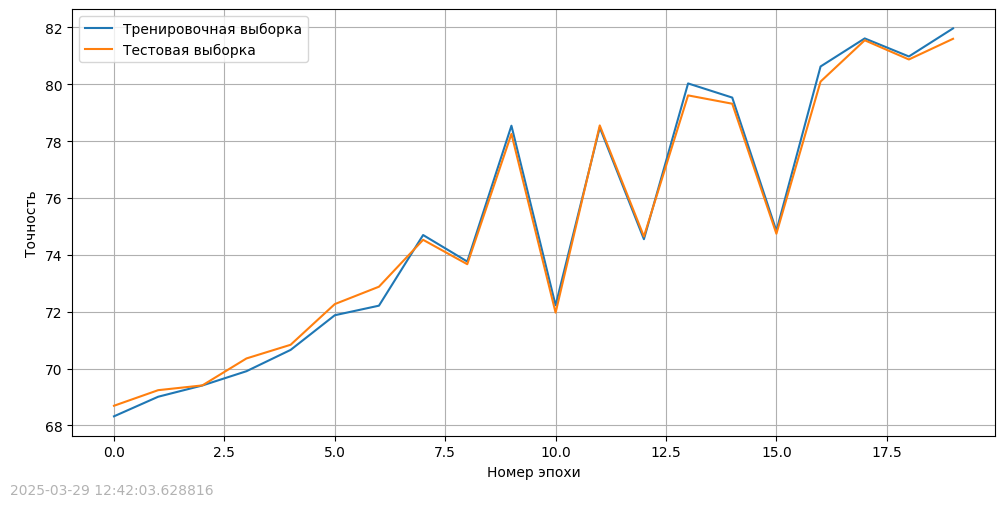

In [ ]:
train_data = AiWritingDataset("interp_extra_train_nn.csv")
test_data = AiWritingDataset("interp_extra_test_nn.csv")
train_dataloader = DataLoader(train_data, batch_size=512, shuffle=True, num_workers=0)
test_dataloader = DataLoader(test_data, batch_size=256, shuffle=False, num_workers=0)

net = DenseNetwork(19, 32, 1, 5, 0.1)
print(net)
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda', 0)

net = net.to(device)

loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=2e-2)

train_losses, test_losses, train_accs, test_accs = training_loop(
    n_epochs=20, test_every_it=1, network=net, loss_fn=loss_fn,
    optimizer=optimizer, dl_train=train_dataloader, dl_test=test_dataloader, device=device
)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(train_accs, label="Тренировочная выборка")
ax.plot(test_accs, label="Тестовая выборка")
ax.set_xlabel("Номер эпохи")
ax.set_ylabel("Точность")
ax.grid(True)
ax.legend()

fig.text(
    0.0, 0.0, str(datetime.now()),
    fontsize=10, color='gray', alpha=0.6,
)

fig.tight_layout()
plt.savefig('interp_nn.png', bbox_inches='tight', dpi=100)
plt.show()

In [ ]:
torch.save(net.state_dict(), "interp_extra_sigmoid.pth")